In [166]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore', category=DeprecationWarning)

We load the supervised dataset first, as requested by the exercise. 

In [167]:
df = pd.read_csv('exam_superv.csv')
print("Dataset size {}".format(df.shape))
df.columns = df.columns.astype(str)
df.head()

Dataset size (1200, 4)


,0,1,y,2
0,1.589942,2.977770,0,1.953805
1,2.908437,1.837522,1,1.510049
2,3.284091,1.818476,1,3.307287
3,3.148717,2.071991,1,3.452021
4,2.116881,2.133874,0,2.157870


(array([591.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 609.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

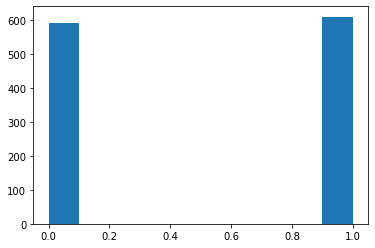

In [168]:
all_labels = pd.unique(df['y'])
counts, bins = np.histogram(df['y'])
df.columns = df.columns.astype(str)
plt.hist(df['y'])

In [169]:
X = df.drop(columns=['y'])
y = df['y']
X.head()

,0,1,2
0,1.589942,2.977770,1.953805
1,2.908437,1.837522,1.510049
2,3.284091,1.818476,3.307287
3,3.148717,2.071991,3.452021
4,2.116881,2.133874,2.157870


Let's examine the pairplots in order to see which columns have the best correlations.

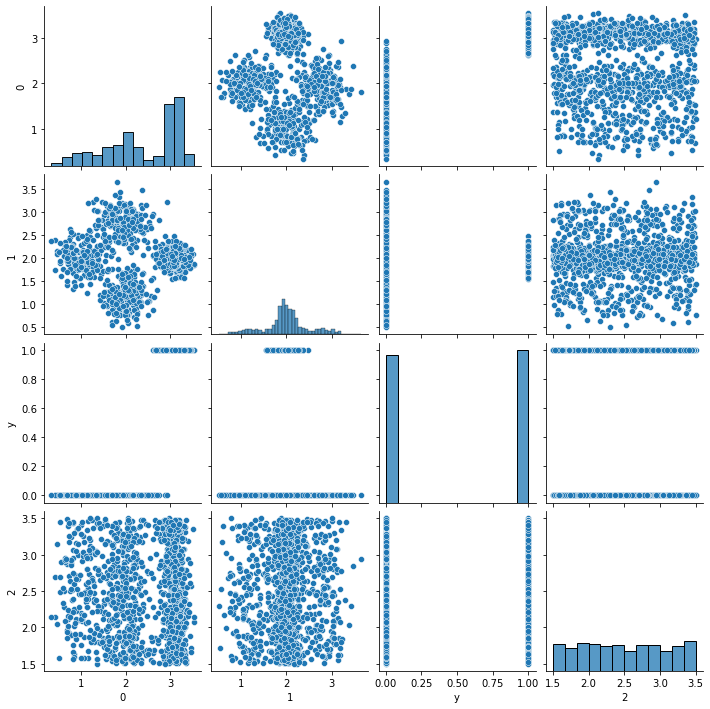

In [170]:
sns.pairplot(df)

The most interesting columns in this case are columns (0,1), since we can see very definite and distinguishable clusters in the pairplots created by these columns. We can also see that the graph of (2, y) is very much similar to the histogram of y, indicating that it has little influence on the final labeling. 

In [171]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score

# lets drop column 2 as we've said
X = X.drop(columns='2')

k_range = list(range(2,11)) # set the range of k values to test 
linkage_methods = ['ward', 'complete', 'average', 'single']
params = {'linkage' : linkage_methods}
pg = list(ParameterGrid(params))

needed_clusters = len(np.unique(y))

ac_results = []

for i in range(len(pg)): 
    ac_model = AgglomerativeClustering(n_clusters=needed_clusters, linkage=pg[i]['linkage'])
    y_pred = ac_model.fit_predict(X)
    ac_results.append([pg[i]['linkage'], silhouette_score(X, y_pred)])

ac_result_table = (pd.DataFrame(columns=['linkage_methods', 'sil_score'], data=ac_results)
                  .sort_values(by='sil_score', ascending=False))
ac_result_table.head(5)

,linkage_methods,sil_score
0,ward,0.553130
2,average,0.521578
1,complete,0.519470
3,single,0.215997


In [172]:
min_points = 2*X.shape[1]
param_grid = {'eps': list(np.arange(0.01, 1, 0.01)), 'min_samples': list(range(min_points-3,min_points+3,1))}
params = list(ParameterGrid(param_grid))

dbscan_out = pd.DataFrame(columns = ['eps','min_samples','silhouette', 'unclust%'])

for i in range(len(params)) : 
    db_estimator = DBSCAN(**(params[i])) ## quick way to pass params
    
    y_db = db_estimator.fit_predict(X)
    cluster_labels_all = np.unique(y_db) ## self explanatory...
    n_clusters = len(cluster_labels_all[cluster_labels_all != -1])

    if n_clusters == needed_clusters:   
        y_db_clustered = y_db[y_db != -1] # select only the labels such that it is not -1 (noise)       
        X_cl = X.iloc[y_db != -1, :]  # ignore noise in the dataset

        silhouette = silhouette_score(X_cl, y_db_clustered)
        uncl_p = (1 - (y_db_clustered.shape[0] / y_db.shape[0])) * 100
        
        dbscan_out.loc[len(dbscan_out)] = [db_estimator.eps, db_estimator.min_samples, silhouette, uncl_p]

dbscan_out.sort_values(by=['silhouette'], ascending=False).head(10)

,eps,min_samples,silhouette,unclust%
0,0.15,4.0,0.571673,2.666667
3,0.16,5.0,0.569389,2.250000
2,0.16,4.0,0.566636,1.750000
8,0.18,6.0,0.566400,1.750000
5,0.17,5.0,0.566375,1.666667
4,0.17,4.0,0.563942,1.333333
9,0.19,6.0,0.563013,1.416667
7,0.18,5.0,0.562483,1.250000
6,0.18,4.0,0.561564,1.083333
1,0.16,3.0,0.296008,1.333333


Using with agglomerative clustering, we get a very low silhouette score, even if the parameters are tuned. On the other hand, we obtain a much higher silhouette score using DBSCAN, but we have a very high percentage of unclustered data. 

To better understand the results, let's plot them and compare the two best clustering schemes obtained with each method (w.r.t. the silhouette score).

In [176]:
from sklearn.metrics import accuracy_score, confusion_matrix

db_estimator = DBSCAN(eps=0.15, min_samples=4)
y_db = db_estimator.fit_predict(X)
print(accuracy_score(y, y_db))
confusion_matrix(y, y_db)


0.9708333333333333


array([[  0,   0,   0],
       [ 32, 556,   3],
       [  0,   0, 609]])

When choosing the right tradeoff for eps and min_samples, the accuracy score is quite high. As we can see, label 1 was always predicted right, while label 0 is the most affected by noise. 

<AxesSubplot:xlabel='0', ylabel='1'>

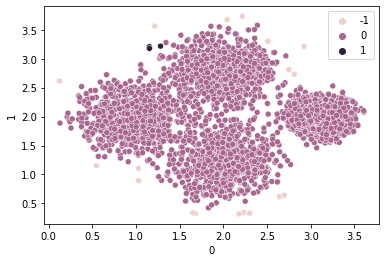

In [182]:
df_un = pd.read_csv('exam_unsuperv.csv')
df_un = df_un.drop(columns='2') # applying transformations

db_estimator = DBSCAN(eps=0.15, min_samples=4)
y_pred = db_estimator.fit_predict(df_un)

sns.scatterplot(x='0', y='1', data=df_un, hue=y_pred)

# sns.scatterplot(x='0', y='1', data=X, hue=y_db)



Even though the model performed very well with the supervised, it does not perform so well with the unsupervised dataset. 